In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import  warnings
warnings.filterwarnings("ignore")

In [2]:
from glob import glob

glob('*')

['fashion-mnist_train.csv',
 'Net',
 'untitled1.py',
 'MobileNetV3',
 'untitled3.py',
 'fashion-mnist_test.csv',
 'f_mnist.ipynb',
 'untitled.py',
 'models.ipynb',
 'untitled2.py',
 'data',
 'cifar10.ipynb']

In [3]:
train_df=pd.read_csv('fashion-mnist_train.csv')
test_df=pd.read_csv('fashion-mnist_test.csv')

In [4]:
classes={
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot',

}

In [5]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import random_split

from sklearn.metrics import confusion_matrix

In [6]:
def imshow(image):
    image=image.numpy()
    plt.imshow(np.transpose(image,(1,2,0)),cmap='binary')
    plt.show()

In [7]:
class EarlyStopper:
    def __init__(self, patience=1,):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss,epoch,model,optimizer):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            
            
            path=model.__class__.__name__
            
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': validation_loss,
            }, path)
            
            
            
            
        elif validation_loss >self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [8]:
class AddGaussianNoise():
    def __init__(self,mean=0.,std=0.25):
        self.mean=mean
        self.std=std
        
    
    def __call__(self,tensor):
        return tensor+torch.rand(tensor.shape)*self.std+self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [9]:
class Cdataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe=dataframe
        self.transform=transform
    
    def __len__(self):
        return self.dataframe.shape[0]
        
    def __getitem__(self,idx):
        image=self.dataframe.iloc[idx,1:]
        image=image.values.reshape(28,28,1)/255.0
        image=transforms.ToTensor()(image)
        image=image.to(torch.float32)
        label=self.dataframe.iloc[idx,0]
        if self.transform:
            image=self.transform(image)
        return image,label
    

transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(34),
    transforms.ToTensor(),
    AddGaussianNoise(),
])
transform_t=transforms.Compose([
    transforms.Resize(34)
])

df=Cdataset(train_df,transform)
test=Cdataset(test_df,transform_t)

In [10]:
train,val=random_split(df,[0.85,0.15])

In [11]:
trainloader=DataLoader(train,batch_size=512,shuffle=True,num_workers=14)
valloader=DataLoader(val,batch_size=600,shuffle=False,num_workers=14)
testloader=DataLoader(test,batch_size=600,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


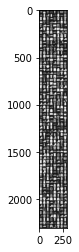

In [12]:
image,label=next(iter(trainloader))
imshow(make_grid(image))

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,96,7,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.batch1=nn.BatchNorm2d(96)
        
        self.conv2=nn.Conv2d(96,80,5,padding=1)
        self.batch2=nn.BatchNorm2d(80)

        self.conv3=nn.Conv2d(80,96,5,padding=1)
        self.batch3=nn.BatchNorm2d(96)

        self.conv4=nn.Conv2d(96,64,3,padding=1)
        self.batch4=nn.BatchNorm2d(64)

        self.fc1=nn.Linear(1024,512)
        self.batch5=nn.BatchNorm1d(512)
        self.drop=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,256)
        self.batch6=nn.BatchNorm1d(256)
        self.drop1=nn.Dropout(0.5)
        self.fc3=nn.Linear(256,10)
        
    def forward(self,x):
        x=self.pool(self.batch1(F.relu(self.conv1(x))))
        x=self.pool(self.batch2(F.relu(self.conv2(x))))
        x=self.batch3(F.relu(self.conv3(x)))
        x=self.batch4(F.relu(self.conv4(x)))
        x=torch.flatten(x,1)
        x=self.batch5(F.relu(self.fc1(x)))
        x=self.drop(x)
        x=self.batch6(F.relu(self.fc2(x)))
        x=self.drop1(x)
        x=self.fc3(x)
        return x

n=Net()

In [14]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(n.parameters(),lr=0.01)
early_stopper=EarlyStopper(10)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.3,patience=5)

In [15]:
import time

In [16]:
y_true=[]
y_pred=[]


def train(epochs,model,optimizer,early_stopper,lr_schedule=None):
    
    global y_true
    global y_pred
    
    y_true=[]
    y_pred=[]
    
    for epoch in range(epochs):
        st=time.monotonic()
        total=0
        correct=0
        running_loss=0

        for data in trainloader:
            inputs,labels=data
            optimizer.zero_grad()
            output=model(inputs)
            
            y_true.extend(labels)
            
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()

            total+=labels.size(0)
            correct+=(torch.max(output,1)[1]==labels).sum().item()
            
            y_pred.extend(torch.max(output,1)[1])
            
            running_loss+=loss.item()

        val_correct=0
        val_total=0
        val_loss=0
        with torch.no_grad():
            for data in valloader:
                images,labels=data
                outputs=model(images)
                loss=criterion(outputs,labels)
                _,predicted=torch.max(outputs.data,1)
                val_loss+=loss
                val_total+=labels.size(0)
                val_correct+=(predicted==labels).sum().item()
        
        lr_schedule.step(val_loss,)

        if early_stopper.early_stop(val_loss,epoch,model,optimizer):
            break
        
        
        
        en=time.monotonic()
        print(f'[{en-st :.1f}s] [{epoch + 1}/{epochs}] train_loss: {running_loss / len(trainloader):.3f}, train acc : { (correct/total)*100 :.3f}%, val_loss: {val_loss / len(trainloader):.3f}, val_acc : {(val_correct/val_total)*100 :.3f}% ')


In [17]:
train(70,n,optimizer,early_stopper,lr_scheduler)

[58.9s] [1/70] train_loss: 0.736, train acc : 72.386%, val_loss: 0.078, val_acc : 80.322% 
[57.6s] [2/70] train_loss: 0.438, train acc : 83.939%, val_loss: 0.060, val_acc : 86.067% 
[57.0s] [3/70] train_loss: 0.359, train acc : 87.037%, val_loss: 0.050, val_acc : 87.911% 
[57.2s] [4/70] train_loss: 0.327, train acc : 88.112%, val_loss: 0.048, val_acc : 88.778% 
[57.4s] [5/70] train_loss: 0.294, train acc : 89.220%, val_loss: 0.046, val_acc : 89.089% 
[57.7s] [6/70] train_loss: 0.280, train acc : 89.876%, val_loss: 0.046, val_acc : 88.633% 
[57.0s] [7/70] train_loss: 0.260, train acc : 90.488%, val_loss: 0.043, val_acc : 90.078% 
[57.7s] [8/70] train_loss: 0.245, train acc : 90.992%, val_loss: 0.042, val_acc : 90.133% 
[56.9s] [9/70] train_loss: 0.227, train acc : 91.602%, val_loss: 0.041, val_acc : 90.489% 
[57.1s] [10/70] train_loss: 0.217, train acc : 92.010%, val_loss: 0.040, val_acc : 90.722% 
[56.9s] [11/70] train_loss: 0.212, train acc : 92.290%, val_loss: 0.039, val_acc : 91.011

In [18]:
from torchvision import models

t_model=models.mobilenet_v3_large(pretrained=True)
t_model.features[0][0]=nn.Conv2d(1,16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
t_model.classifier=nn.Sequential(nn.Linear(t_model.classifier[0].in_features,256),
                                 nn.BatchNorm1d(256),
                                 nn.Dropout(0.5),
                                 nn.Linear(256,10))

In [19]:
optimizer1=optim.Adam(t_model.parameters(),lr=0.01)
early_stopper1=EarlyStopper(10)
lr_scheduler1=optim.lr_scheduler.ReduceLROnPlateau(optimizer1,factor=0.3,patience=5)

In [20]:
train(70,t_model,optimizer1,early_stopper1,lr_scheduler1)

[70.2s] [1/70] train_loss: 0.654, train acc : 76.306%, val_loss: 0.062, val_acc : 85.278% 
[70.7s] [2/70] train_loss: 0.378, train acc : 86.429%, val_loss: 0.052, val_acc : 87.689% 
[75.7s] [3/70] train_loss: 0.327, train acc : 88.190%, val_loss: 0.050, val_acc : 88.044% 
[73.7s] [4/70] train_loss: 0.298, train acc : 89.163%, val_loss: 0.046, val_acc : 88.422% 
[83.7s] [5/70] train_loss: 0.277, train acc : 89.939%, val_loss: 0.044, val_acc : 89.200% 
[72.0s] [6/70] train_loss: 0.266, train acc : 90.345%, val_loss: 0.043, val_acc : 89.644% 
[71.5s] [7/70] train_loss: 0.257, train acc : 90.582%, val_loss: 0.041, val_acc : 90.078% 
[72.9s] [8/70] train_loss: 0.251, train acc : 90.827%, val_loss: 0.042, val_acc : 89.978% 
[77.9s] [9/70] train_loss: 0.243, train acc : 91.031%, val_loss: 0.039, val_acc : 90.889% 
[73.5s] [10/70] train_loss: 0.230, train acc : 91.514%, val_loss: 0.040, val_acc : 90.444% 
[70.5s] [11/70] train_loss: 0.224, train acc : 91.816%, val_loss: 0.039, val_acc : 90.944

In [21]:
def test(model):
    st=time.monotonic()

    test_correct=0
    test_total=0
    
    with torch.no_grad():
        for data in testloader:
            images,labels=data
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            test_total+=labels.size(0)
            test_correct+=(predicted==labels).sum().item()
    model_name=model.__class__.__name__ 
    
    en=time.monotonic()

    print(f'[{en-st :.1f}s] {model_name} model test acc : {(test_correct/test_total)*100 :.3f}%')


[5.4s] Net model test acc : 91.190%


<Axes: >

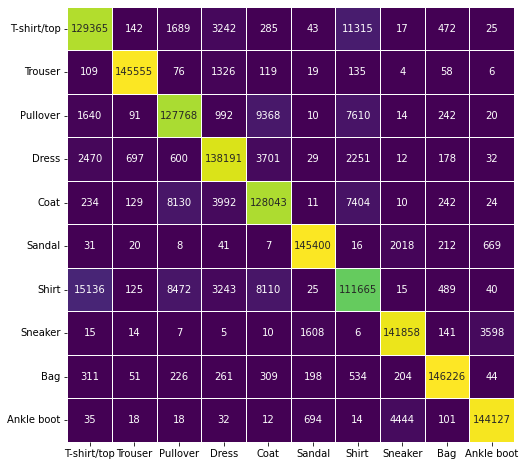

In [22]:
test(n)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true,y_pred),cmap='viridis',annot=True,linewidths=0.5,cbar=False,xticklabels=list(classes.values()),yticklabels=list(classes.values()),fmt='.0f')

[3.3s] MobileNetV3 model test acc : 92.360%


<Axes: >

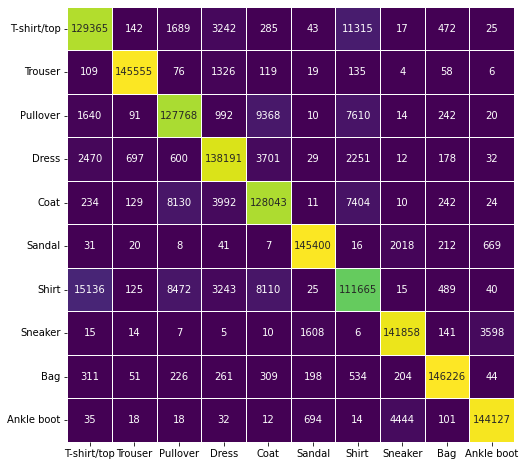

In [23]:
test(t_model)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true,y_pred),cmap='viridis',annot=True,linewidths=0.5,cbar=False,xticklabels=list(classes.values()),yticklabels=list(classes.values()),fmt='.0f')

In [24]:
best_n=Net()
best_n_optimizer=optim.Adam(best_n.parameters())

best_n_checkpoints=torch.load('Net')

In [26]:
best_n.load_state_dict(best_n_checkpoints['model_state_dict'])

<All keys matched successfully>

In [27]:
#best val_loss Net()
test(best_n)

[4.6s] Net model test acc : 90.410%


In [28]:
best_t=models.mobilenet_v3_large(pretrained=True)
best_t.features[0][0]=nn.Conv2d(1,16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
best_t.classifier=nn.Sequential(nn.Linear(t_model.classifier[0].in_features,256),
                                 nn.BatchNorm1d(256),
                                 nn.Dropout(0.5),
                                 nn.Linear(256,10))
best_t_optimizer=optim.Adam(best_n.parameters())
best_t_checkpoints=torch.load('MobileNetV3')


In [29]:
best_t.load_state_dict(best_t_checkpoints['model_state_dict'])

<All keys matched successfully>

In [30]:
#best val_loss MobileNetV3()
test(best_t)

[3.3s] MobileNetV3 model test acc : 91.910%
